## Competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [6]:
def power_competition(n,B,m=150):
        
   np.random.seed(42)
   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []
   delta_list = []
   epsilon = np.random.normal(0, 1, n)
   x = np.random.uniform(0, 5, n)
   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       y = beta1 * x + beta2 * x**2 + epsilon 

       x_sorted_idx = np.argsort(x)  # Indices pour trier x par ordre croissant
       x_sorted = x[x_sorted_idx]  # x trié
       y_sorted = y[x_sorted_idx]  # y correspondant trié

       # Génération de l'ensemble de test indépendant
       x_test = np.sort(np.random.choice(x_sorted, m, replace=True))  # Choix aléatoire avec remplacement
       y_test = np.interp(x_test, x_sorted, y_sorted)  # Interpolation pour obtenir y_test correspondant à x_test               
       
       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          x_train_reshape = x_train.reshape(-1, 1) # fit pour le modèle 

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_a2 = LinearRegression().fit(x_train_quad, y_train)          
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = np.mean(db)
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       delta_list.append(delta)
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return delta_list, esperances, variances, test_statistics, test_alternative, power


In [7]:
delta_list, esperances, variances, test_statistics, test_alternative, power = power_competition(n=150, B=100)
print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")


Espérances: [-0.00240003738380304, 0.007859805813936164, 0.004271020096867309, -0.0010003985717796093, 0.007944162498524154, 0.008193434971094567, 0.06951072842205837, 0.08179453081327724, 0.13510808294239252]
Variances: [0.0006711047597702523, 0.00028362024400552564, 4.910866317805826e-05, 0.00012279412363698963, 8.938741681199317e-05, 0.00012316611632410732, 0.0002567994276892088, 0.00023342543986163534, 0.00023234682166041972]
Statistiques de test: [-0.9264518373840304, 4.6670580549336815, 6.094703168411068, -0.9027848680064389, 8.402527174148732, 7.382787826899709, 43.37653071233481, 53.5365243188981, 88.63657451432391]
Test alternative: [2.58684299338042, -3.0066668989372918, -4.434312012414678, 2.5631760240028285, -6.742136018152342, -5.722396670903319, -41.716139556338426, -51.87613316290169, -86.97618335832749]
Puissance: [0.004842985800732058, 0.9986793549211734, 0.9999953816612304, 0.005185972457242394, 0.9999999999921962, 0.9999999947484137, 1.0, 1.0, 1.0]


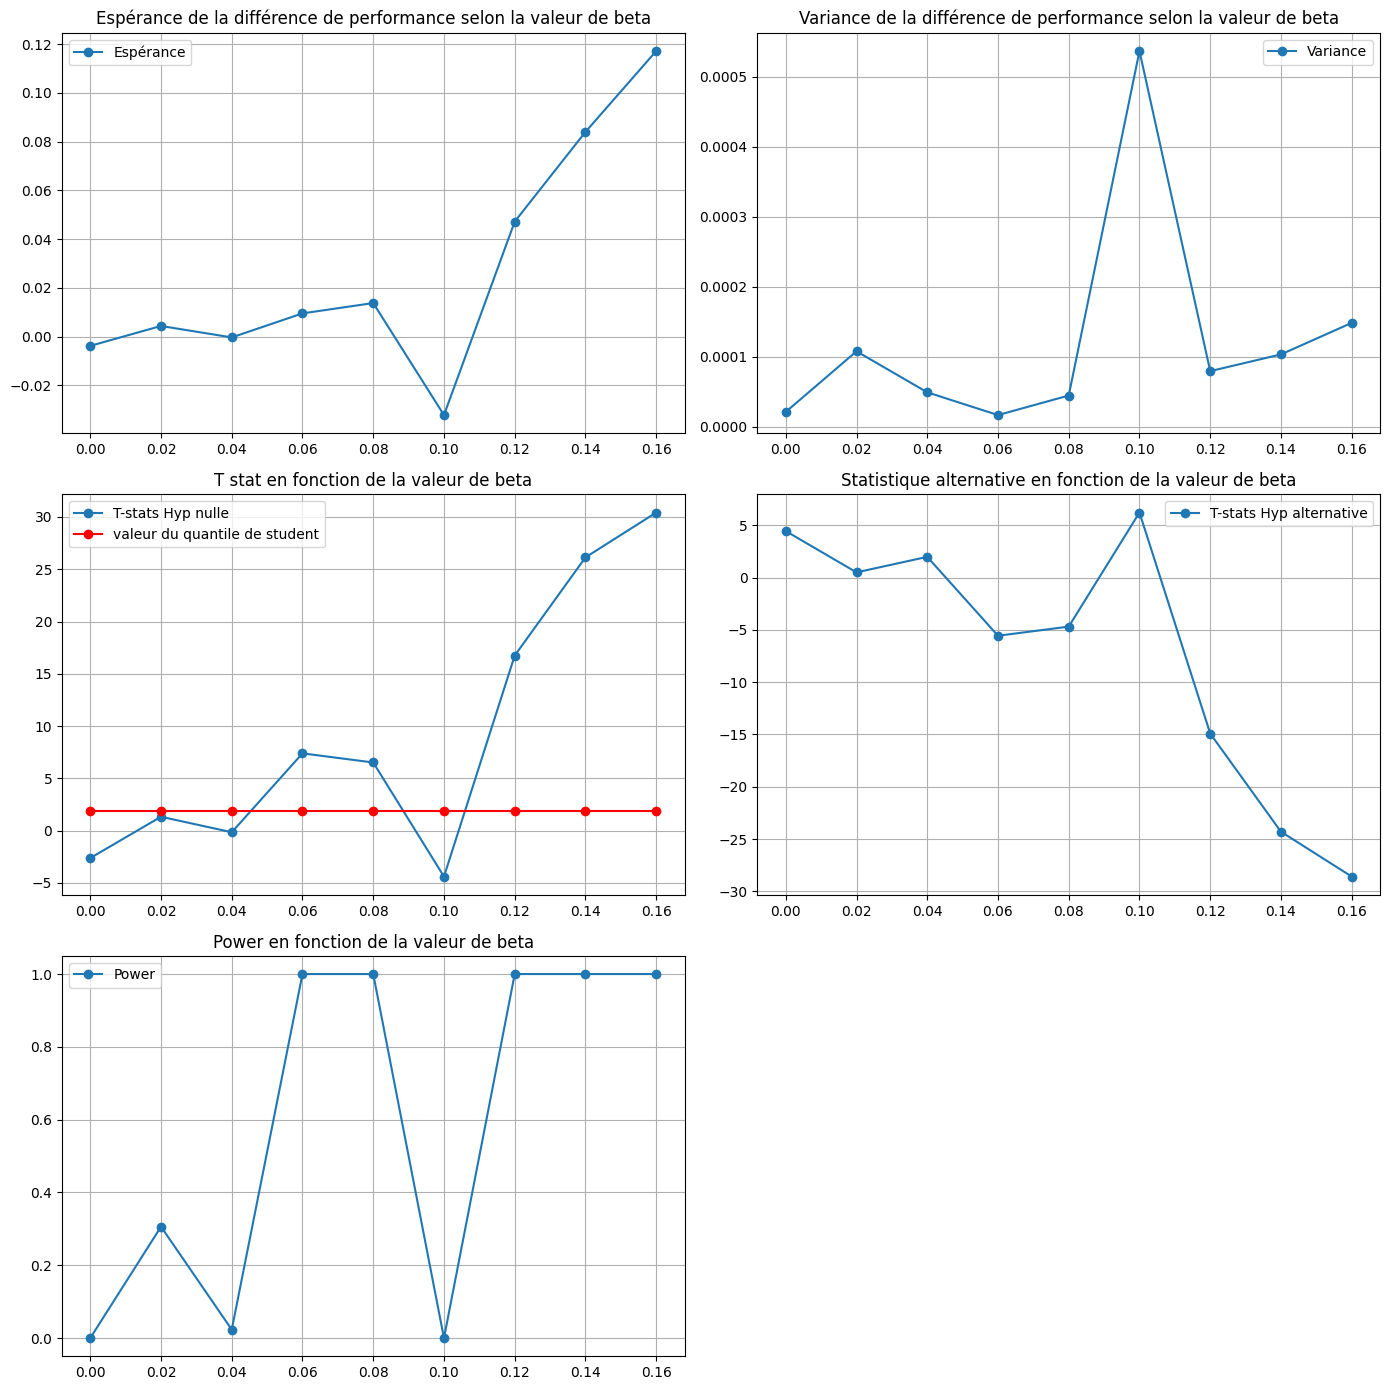

In [8]:
delta_list, esperances, variances, test_statistics, test_alternative, power = power_competition(150, 10)
beta2_values = np.linspace(0, 0.16, 9)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Cinquième sous-graphe : Power
axes[2, 0].plot(beta2_values, power, label='Power', marker='o')
axes[2, 0].set_title('Power en fonction de la valeur de beta')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Cache le 6ème sous-graphe vide
fig.delaxes(axes[2, 1])

# Ajuste la disposition pour éviter les chevauchements
plt.tight_layout()
plt.show()

In [5]:
"""

from sklearn.model_selection import GridSearchCV

# On cherche le meilleur B

param_grid = {'n_bootstrap': [2, 10, 50, 100, 200, 500]}

def evaluate_model_with_bootstrap(n, n_bootstrap):
    esperances, variances, test_statistics, test_alternative, power = power_competition(n, n_bootstrap)
    return np.mean(variances)

best_score = -np.inf
best_params = None
for n_bootstrap in param_grid['n_bootstrap']:
    score = evaluate_model_with_bootstrap(150, n_bootstrap)
    if score > best_score:
        best_score = score      
        best_params = n_bootstrap

print(f'Best number of bootstraps: {best_params}, with score: {best_score}')

"""

Best number of bootstraps: 100, with score: 0.00022908366810424333
